In [1]:
import torch
import wandb
import pprint
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import os
os.environ["http_proxy"]="http://proxy61.iitd.ac.in:3128"
os.environ["https_proxy"]="http://proxy61.iitd.ac.in:3128"

In [10]:
track_columns = ['new node test average_precision',
 'train roc_auc',
 'new node val first_3_roc_auc',
 'new node test first_3_roc_auc',
 'new node test first_3_average_precision',
 'new node val average_precision',
 'new node val first_1_average_precision',
 'new node test first_1_average_precision',
 'new node test first_1_roc_auc',
 'new node test first_10_roc_auc',
 'new node val first_3_average_precision',
 'val average_precision',
 'val roc_auc',
 'new node val roc_auc',
 'new node val first_10_average_precision',
 'new node test roc_auc',
 'train average_precision',
 'test roc_auc',
 'new node val first_1_roc_auc',
 'new node val first_10_roc_auc',
 'test average_precision',
 'new node test first_10_average_precision',
 'train_acc_hist',
 'val_acc_hist',
 'new node val_acc_hist',
 'test_acc_hist',
 'new node test_acc_hist',
 ]
import pandas as pd 
import wandb
api = wandb.Api()

runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", )

for cnt, run in enumerate(tqdm(runs[:6])):
    # Find epoch with best avg precision
    update_run(run)

  0%|          | 0/6 [00:00<?, ?it/s]

tgn-ia-movielens-user2tags-10m-init-time-fourier
26
tgn-ia-slashdot-reply-dir-init-time-fourier
1
tgn-ia-escorts-dynamic-init-time-fourier
58
tgn-ia-digg-reply-init-time-fourier
10
tgn-ia-reality-call-init-time-fourier
97
tgn-ia-retweet-pol-init-time-fourier
52


In [7]:
def update_run(run):
  val_key = 'val average_precision'
  hist = run.history(samples = 200, keys = [val_key])
  hist= hist[val_key]
  best_epoch_num_test = np.argmax(hist[9::10])
  best_epoch_num = np.argmax(hist)
  print(run.name)
  print(best_epoch_num)
  for key in track_columns:
    hist = run.history(samples = 200, keys = [key])[key]
    # print(f"From {run.summary[key]} to ", end ="")
    if 'test' in key:
      run.summary[key] = hist[best_epoch_num_test]
      # print(f"{run.summary[key]}")
    else:
      run.summary[key] = hist[best_epoch_num]
      # print(f"{run.summary[key]}")
  run.summary.update()

### Plotting time transformation function

In [2]:
import sys
sys.path += ['/home/ayush/DyGLib/']
from models.MemoryModel import *
data_names = ['ia-reality-call', 'ia-retweet-pol', 'ia-movielens-user2tags-10m', 'ia-slashdot-reply-dir', 'ia-escorts-dynamic', 'ia-digg-reply']
num_nodes = [27046, 18471, 16530, 51085, 10108, 30400]

In [3]:
def plot_all(call = 'exp', init_weights = 'time-exp', number = 0):
  data_name = data_names[number]
  num_node = num_nodes[number]
  print(number)
  print(data_name)
  run_name = "TGN_seed0_" + data_name + f"nep-128-time-fourier"
  save_model_path = f"/home/ayush/DyGLib/saved_models/TGN/{data_name}/TGN_seed0_tgn-{data_name}-nep-128-time-fourier/TGN_seed0_tgn-{data_name}-nep-128-time-fourier.pkl"
  dynamic_backbone = MemoryModel(node_raw_features=np.zeros((num_node, 172)), edge_raw_features=np.zeros((1720, 172)), neighbor_sampler = None, time_feat_dim=100, model_name="TGN", num_layers=1, num_heads=2, dropout=0.1, total_time=1, use_init_method=True, init_weights=init_weights)
  dynamic_backbone.mlp_for_mean = nn.Sequential(
              nn.Linear(dynamic_backbone.memory_dim, dynamic_backbone.memory_dim)
          )
  link_predictor = MergeLayer(
                  input_dim1=172,
                  input_dim2=172,
                  hidden_dim=172,
                  output_dim=1,
              )
  model = nn.Sequential(dynamic_backbone, link_predictor)
  try:
    model.load_state_dict(torch.load(save_model_path, map_location=None), strict=False)
    x = (torch.arange(0, 500)/500).reshape(-1, 1)
    tt = model[0].time_transformation_for_init
    if call == 'exp':
      lin_out = tt.lin(-x).reshape(-1)
      y = torch.exp(-torch.square(lin_out))
    if call == 'linear':
      y = tt.lin(-x).reshape(-1)
    if call == 'fourier':
      zeros = -x.reshape(-1, 1)
      exp_out = (torch.cos(zeros.unsqueeze(-1) * tt.mask.unsqueeze(0).unsqueeze(1)) * tt.lin[:tt.k]).sum(dim = 2) + torch.sin(zeros.unsqueeze(-1) * tt.mask.unsqueeze(0).unsqueeze(1)  * tt.lin[tt.k:]).sum(dim = 2)
      y = exp_out.reshape(-1)
    if call == 'mlp':
      y = tt.mlp_for_time(-x.reshape(-1, 1)).reshape(-1)
    plt.plot((1 - x).tolist(), y.tolist())
      
    return True
  except Exception as e:
    print(e)
    return False

In [4]:
def plot_all_all(call = 'exp'):
  legends = []
  for j in range(6):
    mask = plot_all(call=f'{call}', init_weights=f'time-{call}', number=j)
    print(mask)
    if mask:
      legends.append(data_names[j])
  plt.title(f'time-{call}')
  plt.legend(legends)
  plt.xlabel(r'Time t: Earliest $\rightarrow$$\rightarrow$$\rightarrow$$\rightarrow$ current')
  plt.ylabel(r'Weight $w(t)$')
  plt.show()
  plt.close()

0
ia-reality-call
True
1
ia-retweet-pol
True
2
ia-movielens-user2tags-10m
True
3
ia-slashdot-reply-dir
True
4
ia-escorts-dynamic
True
5
ia-digg-reply
True


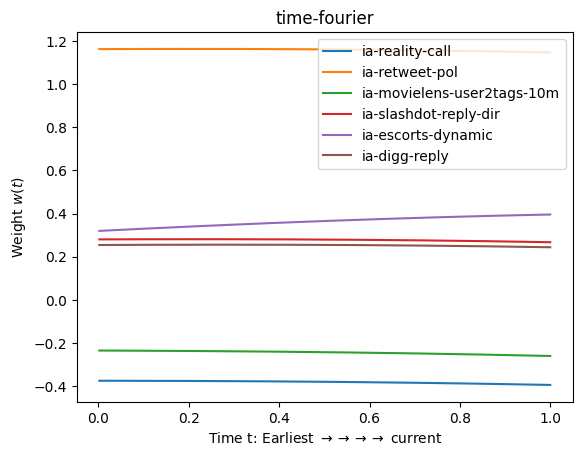

In [5]:
plot_all_all('fourier')

$w_i = \sum_{i=1}^{n_i} w(\frac{(t_i-t_{curr})}{t_{curr}})$

$E_{new} = \frac{\sum{w_i \cdot E_i}}{\sum{w_i}}$

$w_{fourier}(t)$

$t$ v/s $w(t)$
curr time instead of total
[1/2^16, .., 2^16]
reparam w/ this
This for MLP:
1 --> d --> W(dxd) --> d -->ReLU--> d -->W(dx1) --> 1 

[0, 1/root(d)]

0
ia-reality-call
True
1
ia-retweet-pol
True
2
ia-movielens-user2tags-10m
True
3
ia-slashdot-reply-dir
True
4
ia-escorts-dynamic
True
5
ia-digg-reply
True


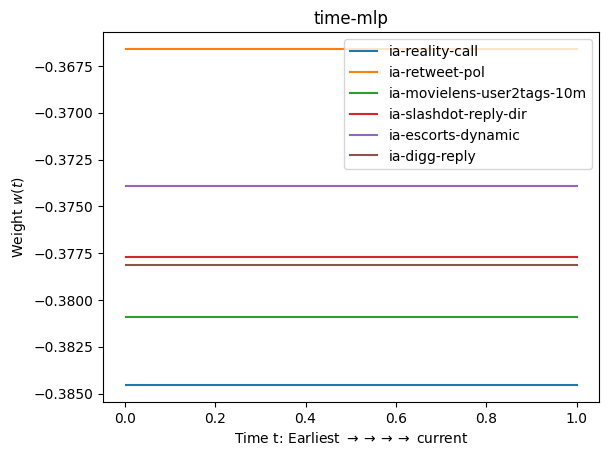

In [104]:
plot_all_all('mlp')

0
ia-reality-call
True
1
ia-retweet-pol
True
2
ia-movielens-user2tags-10m
True
3
ia-slashdot-reply-dir
True
4
ia-escorts-dynamic
[Errno 2] No such file or directory: '/home/ayush/DyGLib/saved_models/TGN/ia-escorts-dynamic/TGN_seed0_tgn-ia-escorts-dynamic-nep-exp/TGN_seed0_tgn-ia-escorts-dynamic-nep-exp.pkl'
False
5
ia-digg-reply
[Errno 2] No such file or directory: '/home/ayush/DyGLib/saved_models/TGN/ia-digg-reply/TGN_seed0_tgn-ia-digg-reply-nep-exp/TGN_seed0_tgn-ia-digg-reply-nep-exp.pkl'
False


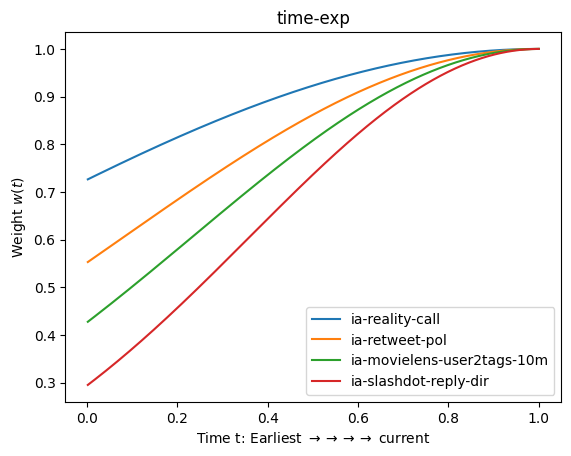

In [105]:
plot_all_all('exp')

0
ia-reality-call
True
1
ia-retweet-pol
True
2
ia-movielens-user2tags-10m
True
3
ia-slashdot-reply-dir
True
4
ia-escorts-dynamic
[Errno 2] No such file or directory: '/home/ayush/DyGLib/saved_models/TGN/ia-escorts-dynamic/TGN_seed0_tgn-ia-escorts-dynamic-nep-linear/TGN_seed0_tgn-ia-escorts-dynamic-nep-linear.pkl'
False
5
ia-digg-reply
[Errno 2] No such file or directory: '/home/ayush/DyGLib/saved_models/TGN/ia-digg-reply/TGN_seed0_tgn-ia-digg-reply-nep-linear/TGN_seed0_tgn-ia-digg-reply-nep-linear.pkl'
False


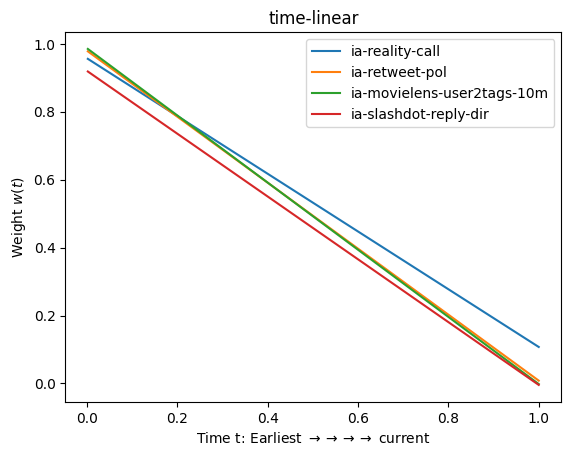

In [106]:
plot_all_all('linear')

In [ ]:
for data_name, num_node in zip(data_names, num_nodes):
  print(data_name)
  run_name = "TGN_seed0_" + data_name + "nep-exp"
  save_model_path = f"/home/ayush/DyGLib/saved_models/TGN/{data_name}/TGN_seed0_tgn-{data_name}-nep-exp/TGN_seed0_tgn-{data_name}-nep-exp.pkl"
  dynamic_backbone = MemoryModel(node_raw_features=np.zeros((num_node, 172)), edge_raw_features=np.zeros((1720, 172)), neighbor_sampler = None, time_feat_dim=100, model_name="TGN", num_layers=1, num_heads=2, dropout=0.1, total_time=1, use_init_method=True, init_weights='time-exp')
  dynamic_backbone.mlp_for_mean = nn.Sequential(
              nn.Linear(dynamic_backbone.memory_dim, dynamic_backbone.memory_dim)
          )
  link_predictor = MergeLayer(
                  input_dim1=172,
                  input_dim2=172,
                  hidden_dim=172,
                  output_dim=1,
              )
  model = nn.Sequential(dynamic_backbone, link_predictor)
  try:
    model.load_state_dict(torch.load(save_model_path, map_location=None), strict=False)
  except Exception as e:
    continue
  x = (torch.arange(0, 500)/500).reshape(-1, 1)
  tt = model[0].time_transformation_for_init
  lin_out = tt.lin(-x/tt.total_time).reshape(-1)
  exp_out = torch.exp(-torch.square(lin_out))
  plt.plot(x.tolist(), exp_out.tolist())
plt.title(f'time-exp')
plt.legend(data_names)
plt.show()
plt.close()

In [ ]:
for data_name, num_node in zip(data_names, num_nodes):
  print(data_name)
  run_name = "TGN_seed0_" + data_name + "nep-exp"
  save_model_path = f"/home/ayush/DyGLib/saved_models/TGN/{data_name}/TGN_seed0_tgn-{data_name}-nep-exp/TGN_seed0_tgn-{data_name}-nep-exp.pkl"
  dynamic_backbone = MemoryModel(node_raw_features=np.zeros((num_node, 172)), edge_raw_features=np.zeros((1720, 172)), neighbor_sampler = None, time_feat_dim=100, model_name="TGN", num_layers=1, num_heads=2, dropout=0.1, total_time=1, use_init_method=True, init_weights='time-exp')
  dynamic_backbone.mlp_for_mean = nn.Sequential(
              nn.Linear(dynamic_backbone.memory_dim, dynamic_backbone.memory_dim)
          )
  link_predictor = MergeLayer(
                  input_dim1=172,
                  input_dim2=172,
                  hidden_dim=172,
                  output_dim=1,
              )
  model = nn.Sequential(dynamic_backbone, link_predictor)
  try:
    model.load_state_dict(torch.load(save_model_path, map_location=None), strict=False)
  except Exception as e:
    continue
  x = (torch.arange(0, 500)/500).reshape(-1, 1)
  tt = model[0].time_transformation_for_init
  lin_out = tt.lin(-x/tt.total_time).reshape(-1)
  exp_out = torch.exp(-torch.square(lin_out))
  plt.plot(x.tolist(), exp_out.tolist())
plt.title(f'time-exp')
plt.legend(data_names)
plt.show()
plt.close()

In [4]:
model[0].mlp_for_mean[0].weight

Parameter containing:
tensor([[-0.0200, -0.0731,  0.0685,  ...,  0.0117, -0.0300, -0.0309],
        [ 0.0549, -0.0448,  0.0401,  ..., -0.0024,  0.0332,  0.0508],
        [ 0.0505,  0.0608, -0.0297,  ...,  0.0253,  0.0108, -0.0385],
        ...,
        [ 0.0221, -0.0065, -0.0267,  ..., -0.0116, -0.0245, -0.0227],
        [ 0.0191, -0.0121, -0.0740,  ...,  0.0283, -0.0192, -0.0513],
        [-0.0679,  0.0255, -0.0251,  ..., -0.0667, -0.0597, -0.0051]],
       requires_grad=True)

In [8]:
def get_average_over_last_five_epochs(run_id):
  # Takes wandb run id and returns average of last 5 readings of the following metrics
  # new node test average_precision
  # test average_precision
  # test roc_auc
  # new node test roc_auc
  api = wandb.Api()
  run = api.run(f"/fb-graph-proj/fb-graph-proj-dyglib/runs/{run_id}")
  index = torch.argmax(torch.tensor(run.history()["val average_precision"].tolist()))
  METRICS_LIST = ["new node test average_precision", "test average_precision", "test roc_auc", "new node test roc_auc"]
  avg_metric = {}
  for metric in METRICS_LIST:
    avg_metric[metric] = round(float(100 * torch.nanmean(torch.tensor(run.history()[metric].tolist()))), 2)
  print(run.config["dataset"])
  pprint.pprint(avg_metric)
  # return avg_metric

## Generating combined histogram of acc v/s count for all nodes.

In [47]:
def smooth(tensor):
  smoothed_tensor = tensor.clone()
  for idx in range(len(tensor)):
    start_index = max(0, idx - 10)
    end_index = min(len(tensor), idx + 11)  # Adjusted to include the 10 elements after NaN
    
    # Smooth values using surrounding indices
    smoothed_value = torch.nanmean(tensor[start_index:end_index])
    
    # Replace NaN value with smoothed value
    smoothed_tensor[idx] = smoothed_value
  return smoothed_tensor.numpy()

In [48]:
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import torch

def generate_combine_hists(data_name):
  api = wandb.Api()
  runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib")
  filt_runs = [run for run in runs if run.config['dataset'] == data_name][:5]
  # print(len(filt_runs), [run.id for run in filt_runs])
  for run in filt_runs:
    update_run(run)
  for hist_name in ['train_acc_hist', 'val_acc_hist', 'new node val_acc_hist', 'test_acc_hist', 'new node test_acc_hist']:
    plt.figure(figsize= (8, 6))
    plt.title(f"{hist_name} for {filt_runs[0].config['dataset']}")
    val_arr = []
    for run in filt_runs:
      hist = run.summary[hist_name]
      vals, bins = hist['values'], hist['bins']
      vals = [float(val) for val in vals]
      vals = smooth(torch.tensor(vals))
      val_arr.append(vals)
      # spl = make_interp_spline(bins[1:], vals, k=15)
      # x_new = np.linspace(bins[1], bins[-1], 200)
      # y_smooth = spl(x_new)
      # plt.plot(x_new, y_smooth)
      plt.plot(bins[1:], vals)
    plt.ylim([np.nanmin([np.nanmin(vals) for vals in val_arr]), 1])
    # plt.stackplot(bins[1:], val_arr[0], val_arr[1], step='post', labels=["-".join(run.name.split("-")[5:]) for run in filt_runs])
    # plt.hist(val_arr, bins = bins, stacked=True, color = ['red', 'orange', 'green', 'blue', 'grey'], label=["-".join(run.name.split("-")[5:]) for run in filt_runs])
    plt.legend(labels=["-".join(run.name.split("-")[len(data_name.split("-")) + 1:]) for run in filt_runs])
    plt.show()
    plt.close()

0
24
18
10
0


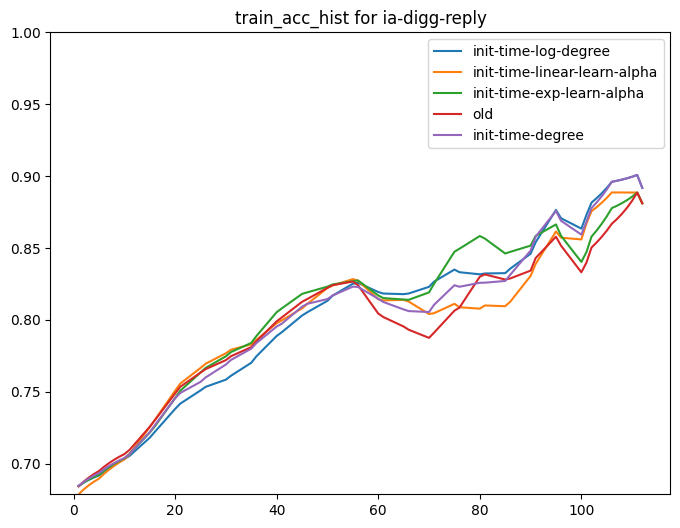

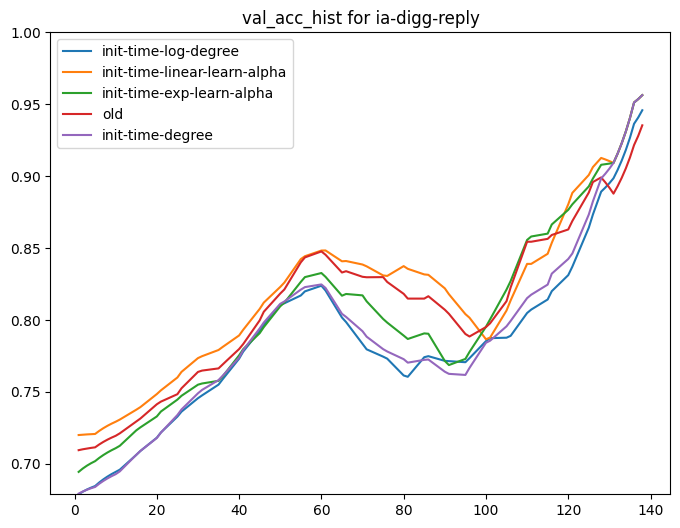

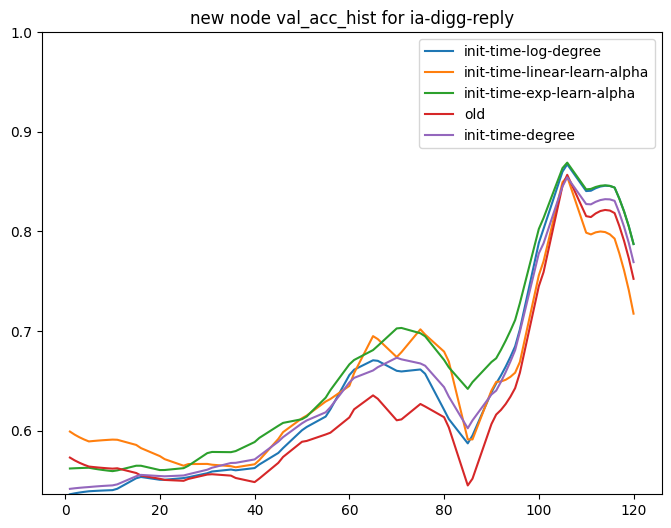

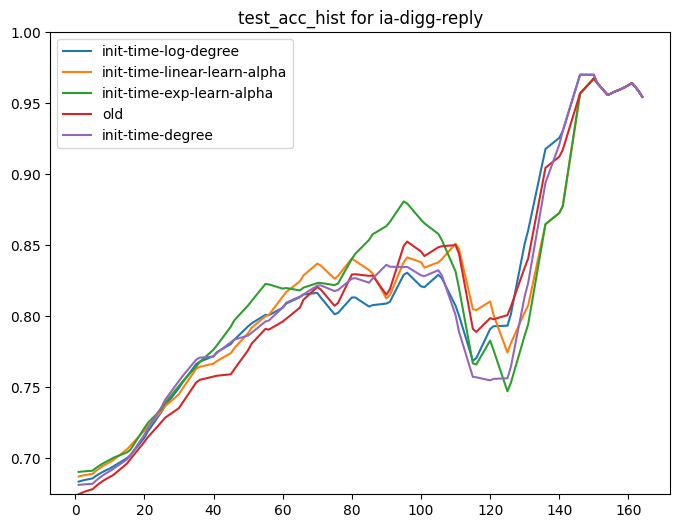

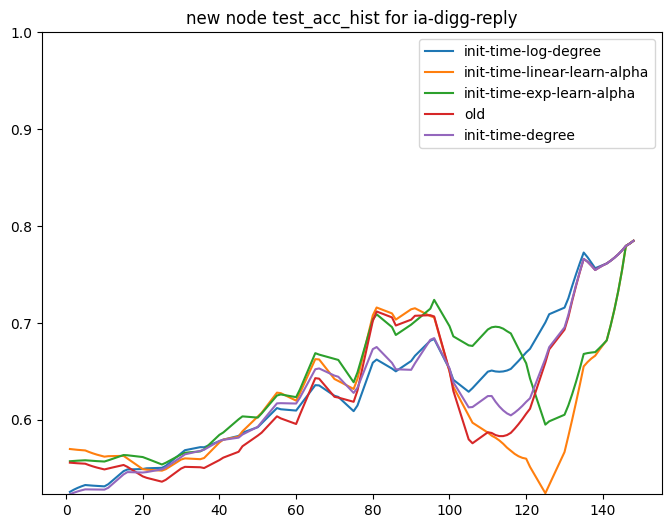

In [56]:
data_name = 'ia-digg-reply'
generate_combine_hists(data_name)

In [18]:
api = wandb.Api()
run = api.run(f"/fb-graph-proj/fb-graph-proj-dyglib/runs/jpp7vme0")
print(run.summary)
run.summary['test_loss'] = 0.2658
run.summary.update()

{'_timestamp': 1704864622.8613284, 'train_loss': {'min': 0.23194398468571345}, 'new node val average_precision': 0.9253885944374476, 'new node test average_precision': 0.9365360489713036, '_step': 41, 'test_loss': 0.2658, 'val average_precision': 0.9642710623015756, 'test average_precision': 0.9598691819415296, 'test roc_auc': {'max': 0.957818487394958}, 'train roc_auc': {'max': 0.9642339940649474}, 'new node test roc_auc': {'max': 0.9301795424690014}, 'train average_precision': 0.9642710623015756, '_wandb': {'runtime': 1468}, 'new node val_loss': {'min': 0.35462927964867136}, 'val roc_auc': {'max': 0.9642339940649474}, 'new node test loss': 0.3415547061269566, 'new node val roc_auc': {'max': 0.9190259221311476}, '_runtime': 1449.64683842659, 'val_loss': {'min': 0.255154035046321}}


In [10]:
import pandas as pd 
import wandb
api = wandb.Api()

runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", filters = {'dataset': "reddit"})

In [12]:
len(runs)

HTTPError: 400 Client Error: Bad Request for url: https://api.wandb.ai/graphql

In [5]:
run = runs[0]

In [7]:
hist = run.history(samples = 200, keys = ['train_acc_hist'])['train_acc_hist']

In [13]:
vals, bins = hist[0]['values'], hist[0]['bins']

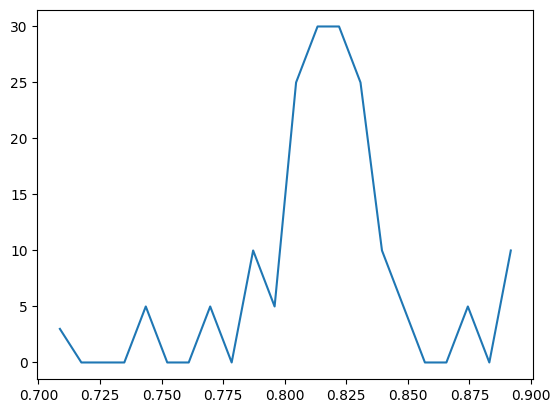

In [17]:
from matplotlib import pyplot as plt
plt.plot(bins[1:], vals)

In [23]:
runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", )

In [32]:
vals, bins

(array([4, 0, 1, 3, 4, 7, 0, 3, 2, 6]),
 array([0.00204809, 0.10064307, 0.19923805, 0.29783303, 0.39642801,
        0.495023  , 0.59361798, 0.69221296, 0.79080794, 0.88940292,
        0.9879979 ]))